**ЖД-путь**

In [5]:
import osmnx as ox
import networkx as nx

graph_moscow = ox.graph_from_place('Saint Petersburg', simplify=False, retain_all=True, custom_filter = '["railway"~"."]')
graph_spb = ox.graph_from_place('Moscow', simplify=False, retain_all=True, custom_filter = '["railway"~"."]')
full_graph = nx.compose_all([graph_moscow, graph_spb])

In [7]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
real_full_graph = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, custom_filter = '["railway"~"."]')

C:\Users\orenc\AppData\Local\Temp\ipykernel_10280\299946497.py:3: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  real_full_graph = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, custom_filter = '["railway"~"."]')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 101 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


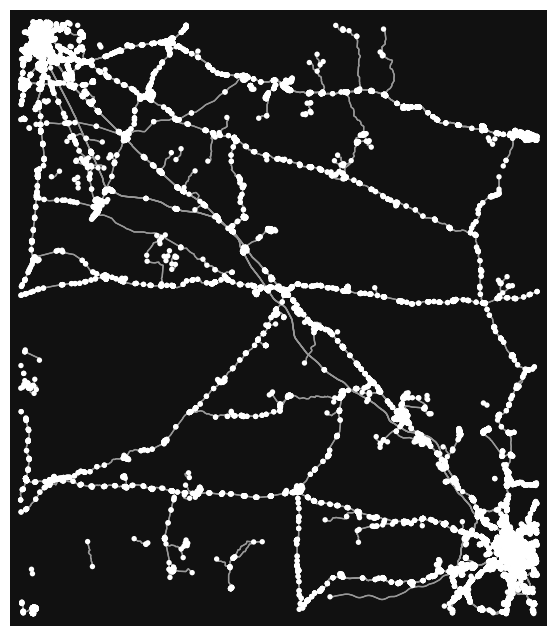

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(real_full_graph)

In [49]:
import osmnx as ox
import pandas as pd
import networkx as nx

def func(x):
    return x[0]

def func_1(x):
    gdf_1 = ox.geocode_to_gdf(x, by_osmid=True)
    return gdf_1[['lat', 'lon']]

def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(func) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(func_1).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

tags = {'railway' : 'station'}

city_from = 'Saint Petersburg'
city_to = 'Moscow'

full_df_from = func_tags(tags, city_from)
full_df_to = func_tags(tags, city_to)

lat_from = list(full_df_from['lat'].values)
lon_from = list(full_df_from['lon'].values)

lat_to = list(full_df_to['lat'].values)
lon_to = list(full_df_to['lon'].values)

full_df_from['new_nodes'] = ox.distance.nearest_nodes(real_full_graph, lon_from, lat_from)
full_df_to['new_nodes'] = ox.distance.nearest_nodes(real_full_graph, lon_to, lat_to)

In [79]:
full_df_to[full_df_to.name.str.contains('Москва')]

,name,lat,lon,geometry,kind_of,new_nodes
17,Москва-Пассажирская,55.778834,37.653721,POINT (37.65372 55.77883),railway,473887009
22,Москва-Пассажирская-Курская,55.757773,37.662790,POINT (37.66279 55.75777),railway,2905348178
25,Москва-Пассажирская-Казанская,55.774267,37.659864,POINT (37.65986 55.77427),railway,921657047
26,Москва-Рижская,55.795067,37.632255,POINT (37.63226 55.79507),railway,11039604812
57,Москва-Сити,55.748305,37.534231,POINT (37.53423 55.74831),railway,1191070208
173,Москва-Товарная,55.745199,37.689308,POINT (37.68931 55.74520),railway,1546711180
174,Москва-Пассажирская-Ярославская,55.778404,37.656762,POINT (37.65676 55.77840),railway,473831701
187,Москва-Товарная-Смоленская,55.772178,37.556495,POINT (37.55650 55.77218),railway,1167208977
195,Москва-Пассажирская-Павелецкая,55.729095,37.641031,POINT (37.64103 55.72909),railway,526282027
214,Москва-Пассажирская-Смоленская,55.776313,37.580362,POINT (37.58036 55.77631),railway,701156589


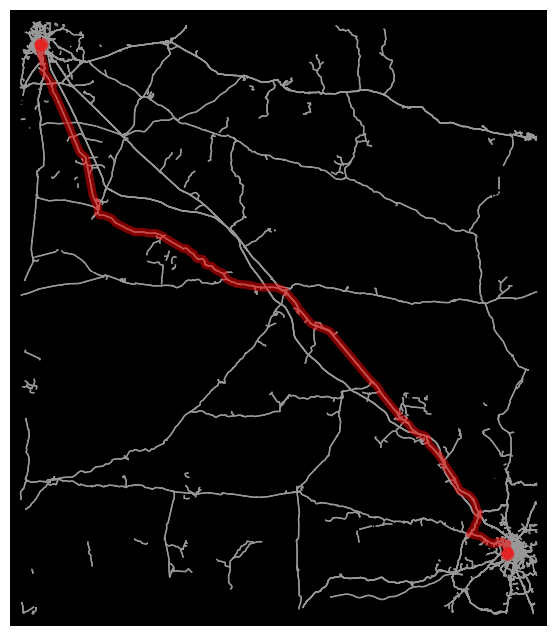

In [82]:
route = nx.shortest_path(real_full_graph, 7734622416, 11034705588)
fig, ax = ox.plot_graph_route(real_full_graph, route, route_linewidth=6, node_size=0, bgcolor='k')

In [2]:
def generate_multindex(route_nodes):
    multiindex_list = []
    # append the index to list
    for u, v in zip(route_nodes[:-1], route_nodes[1:]):
        multiindex_list.append((u, v, 0))
    return multiindex_list


# get edges from from above multidigraph
gdf_nodes, gdf_edges = ox.graph_to_gdfs(real_full_graph)

# generate multiindex based on generated shortest route
multiindex_list = generate_multindex(route)
# fetch edge details based on multi index list
shrt_gdf_edges = gdf_edges[gdf_edges.index.isin(multiindex_list)]
# plot the shortest route on map
shrt_gdf_edges.explore(color="red")

NameError: name 'real_full_graph' is not defined